# Intelligibilité

## Import modules

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from product_sub.infrastructure.dataset_builder import DatasetBuilder
from product_sub.domain.pipeline_creator import PipelineCreator
import product_sub.settings as stg

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN

import pdpbox

## Construction pipeline

In [10]:
dataset_merged = DatasetBuilder(
    filename_bank=stg.FILENAME_BANK, filename_socio=stg.FILENAME_SOCIO_ECO
).create_dataset()
X = dataset_merged.drop(columns=stg.COL_RAW_SUBSCRIPTION)
y = dataset_merged[stg.COL_RAW_SUBSCRIPTION].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=stg.RANDOM_STATE
)

custom_pipeline_accessor = PipelineCreator()
preprocessor = custom_pipeline_accessor.preprocessor

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
smt = SMOTEENN(sampling_strategy=1,random_state=stg.RANDOM_STATE, n_jobs=1)
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

## Construction graphique MDI

In [11]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

# feature_importances

## DecisionTree Classifier

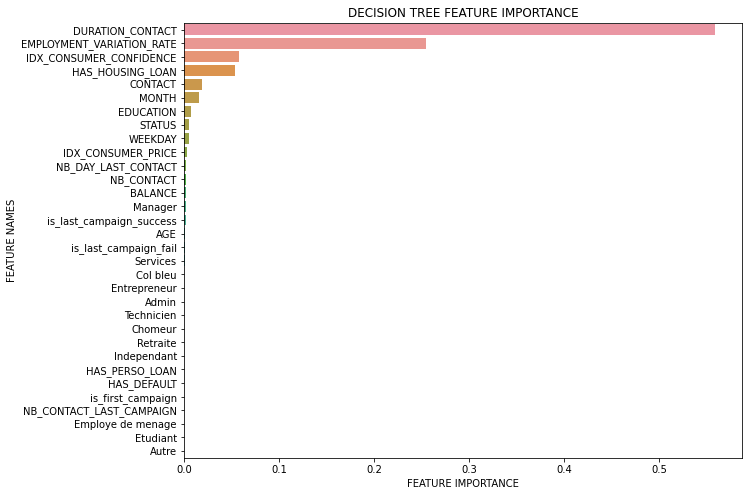

In [19]:
dtc = DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=8,
                                                     min_samples_split=2, min_samples_leaf=1)

dtc = dtc.fit(X_resampled,y_resampled)
plot_feature_importance(dtc.feature_importances_,stg.FINAL_COLUMNS,'DECISION TREE ')

## RandomForest Classifier

In [23]:
rf = RandomForestClassifier(criterion='gini', bootstrap=True, max_features='auto',
                                                    n_estimators=100, max_depth=None, min_samples_split=2, 
                                                    min_samples_leaf=1)

rff = rf.fit(X_resampled,y_resampled)
plot_feature_importance(rff[1].feature_importances_,stg.FINAL_COLUMNS,'RANDOM FOREST ')

NameError: name 'RandomForestClassifier' is not defined

## GradientBoosting Classifier

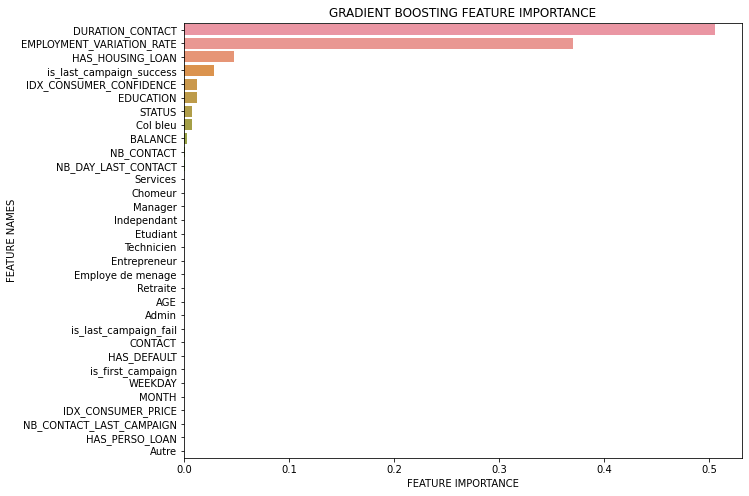

In [22]:
gbc =GradientBoostingClassifier(n_estimators=100, loss='deviance',learning_rate=0.1,
                                                         max_depth=1, random_state=stg.RANDOM_STATE)

gbc.fit(X_resampled,y_resampled)
plot_feature_importance(gbc.feature_importances_,stg.FINAL_COLUMNS,'GRADIENT BOOSTING ')

## AdaBoost Classifier

       MONTH  WEEKDAY  is_first_campaign  nb_contact_last_campaign_inf_4  \
11215      6        4                  1                               0   
31128      4        3                  1                               0   
28041      2        0                  1                               0   

       nb_contact_last_campaign_inf_8  nb_contact_last_campaign_inf_12  \
11215                               0                                0   
31128                               0                                0   
28041                               0                                0   

       nb_contact_last_campaign_sup_12  
11215                                0  
31128                                0  
28041                                0  


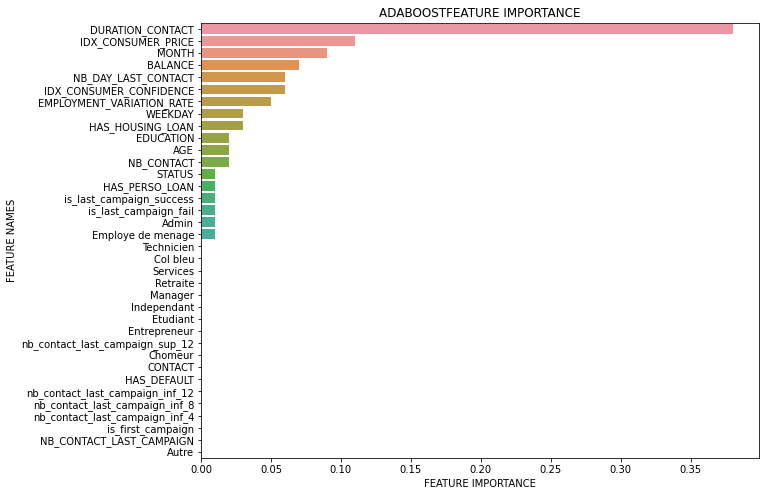

In [53]:
abc = Pipeline(steps=[('preprocessor' , preprocessor),
                      ('abc', AdaBoostClassifier(n_estimators=100, learning_rate=1,
                                                 random_state=10))])

abc = abc.fit(X_train,y_train)
plot_feature_importance(abc[1].feature_importances_,stg.FINAL_COLUMNS,'ADABOOST')